In [1]:
import xarray as xr
import numpy as np 
import os
import types
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import util_cesm
from src import config_cesm
from src.models import models_util

reference_grid = util_cesm.generate_sps_grid()

def load_globals(module):
    """
    Load all global variables declared in a module as a dictionary.
    
    Parameters:
        module (module): The loaded Python module.
    
    Returns:
        dict: A dictionary containing global variables from the module.
    """
    return {
        name: value
        for name, value in vars(module).items()
        if not name.startswith("__") and not isinstance(value, types.ModuleType) and not callable(value)
    }

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords


def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted


def load_model_predictions(config, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    """
    If the config specifies that the predictions are anomalies, then the climatology is added back
    WITH clipping of unphysical values (e.g., if anomaly prediction is -0.5 but the climatology for that
    cell is 0.3, then the resulting value will be clipped to 0).
    """
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, config["EXPERIMENT_NAME"])
    output_path = os.path.join(output_dir, f"{config["MODEL"]}_{config["CHECKPOINT_TO_EVALUATE"]}_predictions.nc")
    predictions = xr.open_dataset(output_path).predictions 

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        predictions = add_climatology(predictions, climatology_broadcasted)

    return predictions 

def load_targets(config, split, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)
    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config["DATA_SPLIT_SETTINGS"]["name"])
    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        targets = add_climatology(targets, climatology_broadcasted)

    return targets

def get_broadcast_climatology(config, split):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)

    empty_predictions_da = models_util.generate_empty_predictions_ds(reference_grid, 
            time_coords, 
            ensemble_members,
            config["MAX_LEAD_MONTHS"], 80, 80).predictions 
    
    return broadcast_climatology_like(config["DATA_SPLIT_SETTINGS"], empty_predictions_da)


def calculate_integrated_area_error(predictions, targets):
    integrated_area_error = xr.DataArray(
        np.empty((config.MAX_LEAD_MONTHS,12)),
        dims = ("lead_time", "month")
    )

    for lead in range(config.MAX_LEAD_MONTHS):
        diff = np.abs(targets.isel(lead_time=lead) - predictions.isel(lead_time=lead))

        area_error = (diff * reference_grid.area).sum(("x","y"))

        avg_error = area_error.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id"))
        integrated_area_error[lead,:] = np.roll(avg_error, lead)

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{config.DATA_CONFIG_NAME}/icefrac_mean.nc").icefrac
    for month in range(12):
        mean_sia = (icefrac_mean.isel(month=month) * reference_grid.area).sum(("x","y"))
        integrated_area_error[:, month] /= mean_sia

    return integrated_area_error

def calculate_rmse(predictions, targets):
    max_lead_months = len(predictions.lead_time)
    
    rmse_da = xr.DataArray(
        np.empty((max_lead_months, 12)),
        dims = ("lead_time", "month")
    )

    for lead in range(max_lead_months):
        squared_residuals = (targets.isel(lead_time=lead) - predictions.isel(lead_time=lead)) ** 2

        mse = squared_residuals.groupby("start_prediction_month.month").mean(("start_prediction_month", "member_id", "x", "y"))
        rmse = np.sqrt(mse)

        rmse_da[lead, :] = np.roll(rmse, lead) 
        
    return rmse_da


def calculate_acc(predictions: xr.DataArray, 
                truth: xr.DataArray, aggregate, climatology_broadcast=None, use_mask=True,
                dim: str = "start_prediction_month") -> xr.DataArray:
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - predictions (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth (xr.DataArray): True anomalies with dimensions including `dim`.
    - aggregate (bool): if True, mean-aggregate down to dims (month, lead_time) 
    - use_mask (bool):  if True, ignores the permanently ice-free zone (as determined by climatology file)  
                                 you need to pass climatology_broadcast if use_mask is True 
    - dim (str): The dimension over which to calculate the ACC. Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if predictions.dims != truth.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")
    
    if use_mask and climatology_broadcast is None:
        raise ValueError("Need to pass climatology_broadcast if use_mask is True!")

    # Remove the mean along the specified dimension
    pred_anomaly = predictions - predictions.mean(dim)
    truth_anomaly = truth - truth.mean(dim)

    if use_mask:
        mask = climatology_broadcast != 0 
        pred_anomaly = pred_anomaly.where(mask)
        truth_anomaly = truth_anomaly.where(mask)

    # Compute numerator (covariance)
    numerator = (pred_anomaly * truth_anomaly).mean(dim)

    # Compute denominator (product of standard deviations)
    pred_std = pred_anomaly.std(dim)
    truth_std = truth_anomaly.std(dim)
    denominator = pred_std * truth_std

    # Compute ACC
    acc = numerator / denominator

    if aggregate:
        if dim == ("x", "y"):
            acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")

        # roll in lead time so that it gets lined up
        acc = xr.concat(
            [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
            dim="lead_time"
        )

    return acc

In [2]:
class ModelDiagnostics():
    """
    This wrapper class is used to evaluate the model predictions for a given experiment configuration.
    """

    def __init__(self, config, climatology_broadcasted: xr.DataArray = None):
        """
        Expected: 
            config (dict)  dictionary of the experiment configuration 

        Optional:
            climatology_broadcasted (xr.DataArray)  climatology broadcasted to the same shape \
                as the model predictions. If not provided, then it will be loaded according to \
                config. Note that this can take a long time, so if possible it is preferable \
                to supply the climatology_broadcasted array.
        """

        self.config = config

        # load climatology if not provided
        if climatology_broadcasted is None:
            self.climatology_broadcasted = get_broadcast_climatology(config, "test")
        else:
            self.climatology_broadcasted = climatology_broadcasted

        # load predictions and targets into xr.DataArray 
        self.predictions = self.load_model_predictions_wrapper()
        self.predictions_anomaly = remove_climatology(self.predictions, self.climatology_broadcasted)

        self.targets = self.load_targets_wrapper()
        self.targets_anomaly = remove_climatology(self.targets, self.climatology_broadcasted)

        # calculate linear difference
        self.diff = self.predictions - self.targets
        
    def load_model_predictions_wrapper(self):
        return load_model_predictions(self.config, climatology_broadcasted=self.climatology_broadcasted) 

    def load_targets_wrapper(self):
        return load_targets(self.config, "test", climatology_broadcasted=self.climatology_broadcasted)
    

    def calculate_acc(self, aggregate, climatology_broadcast=None, use_mask=True,
                dim: str = "start_prediction_month") -> xr.DataArray:
        """
        Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

        Parameters:
        - predictions (xr.DataArray): Predictions (absolute, not anomalies) 
        - truth (xr.DataArray): True anomalies with dimensions including `dim`.
        - aggregate (bool): if True, mean-aggregate down to dims (month, lead_time) 
        - use_mask (bool):  if True, ignores the permanently ice-free zone (as determined by climatology file)  
                                    you need to pass climatology_broadcast if use_mask is True 
        - dim (str): The dimension over which to calculate the ACC. Default is "start_prediction_month".
        
        Returns:
        - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
        """
        # Ensure dimensions match
        if self.predictions_anomaly.dims != self.targets.dims:
            raise ValueError("Predictions and truth must have the same dimensions.")
        
        if use_mask and climatology_broadcast is None:
            raise ValueError("Need to pass climatology_broadcast if use_mask is True!")

        # Remove the mean along the specified dimension
        pred_anomaly = self.predictions_anomaly - self.predictions_anomaly.mean(dim)
        truth_anomaly = self.targets_anomaly - self.targets_anomaly.mean(dim)

        if use_mask:
            mask = climatology_broadcast != 0 
            pred_anomaly = pred_anomaly.where(mask)
            truth_anomaly = truth_anomaly.where(mask)

        # Compute numerator (covariance)
        numerator = (pred_anomaly * truth_anomaly).mean(dim)

        # Compute denominator (product of standard deviations)
        pred_std = pred_anomaly.std(dim)
        truth_std = truth_anomaly.std(dim)
        denominator = pred_std * truth_std

        # Compute ACC
        acc = numerator / denominator

        if aggregate:
            if dim == ("x", "y"):
                acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")

            # roll in lead time so that it gets lined up
            acc = xr.concat(
                [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
                dim="lead_time"
            )

        return acc

In [3]:
# These experiments have the same input configs 
from src.experiment_configs import config_simple_plus_psl_lr1
from src.experiment_configs import config_pred_absolute

anom_config_dict = load_globals(config_simple_plus_psl_lr1)
abs_config_dict = load_globals(config_pred_absolute)

abs_config_dict["CHECKPOINT_TO_EVALUATE"] = "epoch_8"
anom_config_dict["CHECKPOINT_TO_EVALUATE"] = "epoch_8"



In [4]:

climatology_broadcast = get_broadcast_climatology(anom_config_dict, "test")

In [5]:
anom_prediction_diagnostics = ModelDiagnostics(anom_config_dict, climatology_broadcast)
abs_prediction_diagnostics = ModelDiagnostics(abs_config_dict, climatology_broadcast)

Note: the reason that here climatology_anom is nonzero is because the climatology that we are subtracting is computed over the train subset and the climatology prediction uses ensemble-member specific climatology. This is a little confusing and maybe should be ignored.

In [6]:
# make anomaly persistence and climatology predictions (DataArrays)
from src.models import models
anomaly_persistence_predictions = models.anomaly_persistence(config_simple_plus_psl_lr1.DATA_SPLIT_SETTINGS, None).predictions
climatology_predictions = models.climatology_predictions(config_simple_plus_psl_lr1.DATA_SPLIT_SETTINGS, None).predictions

persistence_anom = remove_climatology(anomaly_persistence_predictions, climatology_broadcast)
climatology_anom = remove_climatology(climatology_predictions, climatology_broadcast)

## Illustration of ACC calculation
The anomaly correlation coefficient (ACC) can be calculated spatially (see e.g., https://confluence.ecmwf.int/display/FUG/Section+6.2.2+Anomaly+Correlation+Coefficient) or temporally. 

Text(0.5, 1.0, 'Spatial ACC example: $\\rho$ = 0.608')

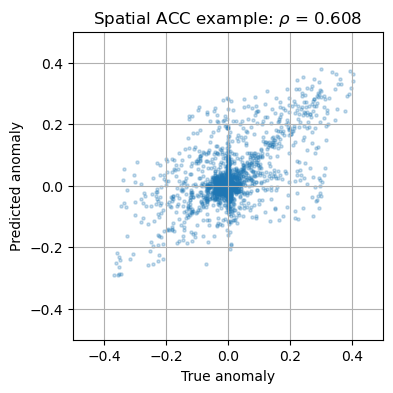

In [8]:
targets_subset = abs_prediction_diagnostics.targets_anomaly.isel(member_id=0, lead_time=0)
predictions_subset = abs_prediction_diagnostics.predictions_anomaly.isel(member_id=0, lead_time=0)

plt.figure(figsize=(4,4))
plt.scatter(targets_subset.isel(start_prediction_month=20).values.flatten(), 
            predictions_subset.isel(start_prediction_month=20).values.flatten(),
            s=5, alpha=0.25)
rho = np.corrcoef(targets_subset.isel(start_prediction_month=20).values.flatten(), 
                predictions_subset.isel(start_prediction_month=20).values.flatten())[0,1]
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.grid(True)
plt.xlabel("True anomaly")
plt.ylabel("Predicted anomaly")
plt.title(rf"Spatial ACC example: $\rho$ = {np.round(rho, 3)}")
#plt.savefig("figures/illustrations/ACC_calculation.jpg", dpi=300, bbox_inches="tight")

## Plot an example of how anomaly prediction messes up coastlines

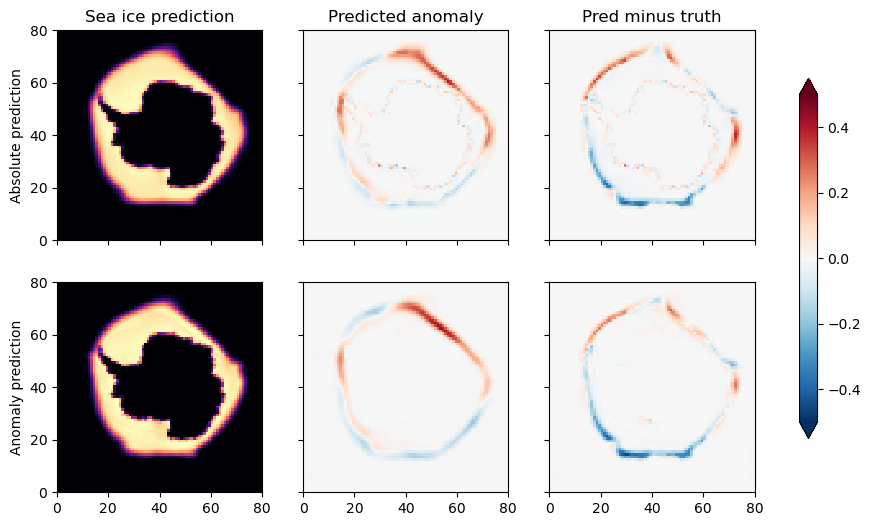

In [6]:
fig, axs = plt.subplots(figsize=(9,6), nrows=2, ncols=3, sharex=True, sharey=True)
subset_params = {
    "member_id": 0,
    "lead_time": 0,
    "start_prediction_month": 6
}


axs[0,0].pcolormesh(abs_prediction_diagnostics.predictions.isel(subset_params), 
    vmin=0, vmax=1, cmap="magma")
axs[1,0].pcolormesh(anom_prediction_diagnostics.predictions.isel(subset_params), 
    vmin=0, vmax=1, cmap="magma")
axs[0,0].set_title("Sea ice prediction")
axs[0,0].set_ylabel("Absolute prediction")
axs[1,0].set_ylabel("Anomaly prediction")

axs[0,1].pcolormesh(abs_prediction_diagnostics.predictions_anomaly.isel(subset_params), 
    vmin=-0.5, vmax=0.5, cmap="RdBu_r")
axs[1,1].pcolormesh(anom_prediction_diagnostics.predictions_anomaly.isel(subset_params), 
    vmin=-0.5, vmax=0.5, cmap="RdBu_r")
axs[0,1].set_title("Predicted anomaly")


cax = axs[0,2].pcolormesh(abs_prediction_diagnostics.diff.isel(subset_params), 
    vmin=-0.5, vmax=0.5, cmap="RdBu_r")
axs[1,2].pcolormesh(anom_prediction_diagnostics.diff.isel(subset_params), 
    vmin=-0.5, vmax=0.5, cmap="RdBu_r")
axs[0,2].set_title("Pred minus truth")

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
plt.colorbar(cax, cax=cbar_ax, orientation='vertical', extend='both')
#plt.savefig("figures/known_issues/coastline_error_landmaskmaybe.jpg", dpi=250, bbox_inches="tight")


## Compute aggregated statistics

In [7]:
anom_acc = anom_prediction_diagnostics.calculate_acc(dim=("x","y"), aggregate=True, use_mask=False)
abs_acc = abs_prediction_diagnostics.calculate_acc(dim=("x","y"), aggregate=True, use_mask=False)

targets_anomaly = anom_prediction_diagnostics.targets_anomaly
climatology_acc = calculate_acc(climatology_anom, targets_anomaly, dim=("x","y"), aggregate=True, use_mask=False)
persistence_acc = calculate_acc(persistence_anom, targets_anomaly, dim=("x","y"), aggregate=True, use_mask=False)

In [8]:
# compute RMSE 
anom_rmse = calculate_rmse(anom_prediction_diagnostics.predictions, anom_prediction_diagnostics.targets)
abs_rmse = calculate_rmse(abs_prediction_diagnostics.predictions, abs_prediction_diagnostics.targets)

persistence_rmse = calculate_rmse(anomaly_persistence_predictions, abs_prediction_diagnostics.targets)
climatology_rmse = calculate_rmse(climatology_predictions, abs_prediction_diagnostics.targets)

## Plot ACC comparison between anom and abs

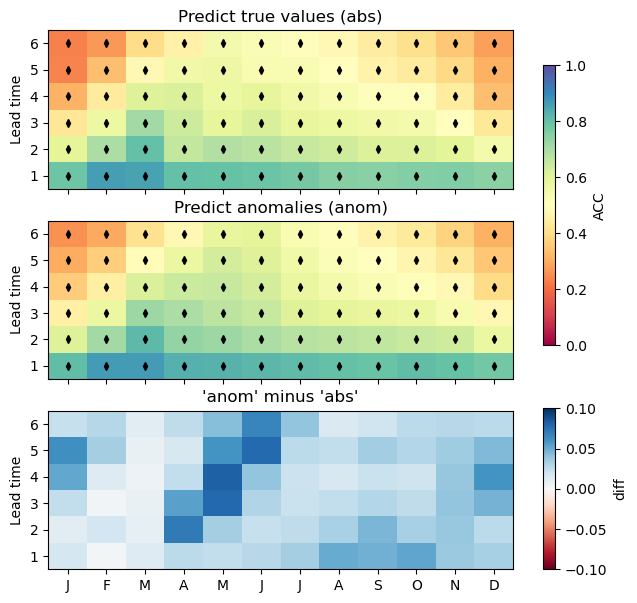

In [131]:
def plot_markers(ax, exceeds_persistence, exceeds_climatology, x_centers, y_centers):
    for i in range(6):
        for j in range(12):
            if exceeds_persistence[i,j] and exceeds_climatology[i,j]:
                ax.plot(x_centers[j], y_centers[i], 'dk', markersize=4) 
            elif exceeds_persistence[i,j]:
                ax.plot(x_centers[j], y_centers[i], '.k', markersize=4) 
            elif exceeds_climatology[i,j]:
                ax.plot(x_centers[j], y_centers[i], 'ok', markersize=4) 

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = abs_acc > persistence_acc
exceeds_climatology = abs_acc > climatology_acc
cax = axs[0].pcolormesh(x, y, abs_acc, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"Predict true values (abs)")
plot_markers(axs[0], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

exceeds_persistence = anom_acc > persistence_acc
exceeds_climatology = anom_acc > climatology_acc
axs[1].pcolormesh(x, y, anom_acc, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Predict anomalies (anom)")
plot_markers(axs[1], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

cax2 = axs[2].pcolormesh(x, y, (anom_acc - abs_acc), cmap='RdBu', shading='flat', vmin=-0.1, vmax=0.1)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("'anom' minus 'abs'")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff', orientation='vertical')
plt.savefig("figures/cesm/initial_experiment/anom_vs_abs_ACC.jpg", dpi=300, bbox_inches='tight')

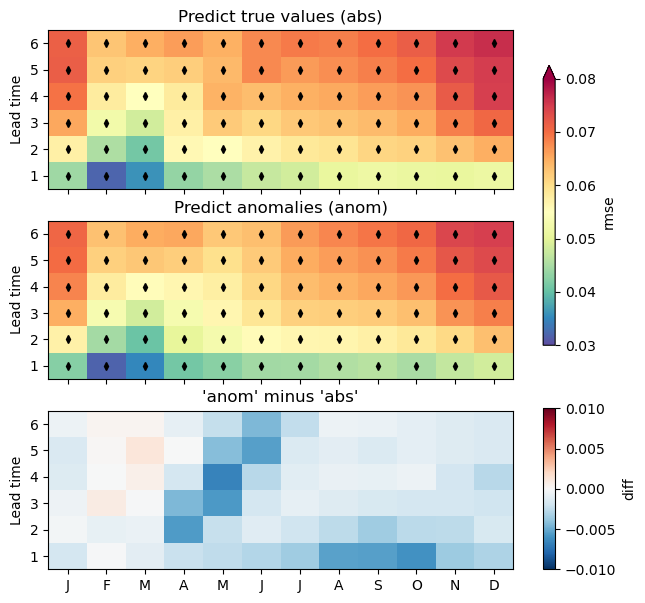

In [132]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = abs_rmse < persistence_rmse
exceeds_climatology = abs_rmse < climatology_rmse
cax = axs[0].pcolormesh(x, y, abs_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.08)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"Predict true values (abs)")
plot_markers(axs[0], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

exceeds_persistence = anom_rmse < persistence_rmse
exceeds_climatology = anom_rmse < climatology_rmse
axs[1].pcolormesh(x, y, anom_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.08)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("Predict anomalies (anom)")
plot_markers(axs[1], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

cax2 = axs[2].pcolormesh(x, y, (anom_rmse - abs_rmse), cmap='RdBu_r', shading='flat', vmin=-0.01, vmax=0.01)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("'anom' minus 'abs'")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'rmse', orientation='vertical', extend='max')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff', orientation='vertical')
plt.savefig("figures/cesm/initial_experiment/anom_vs_abs_rmse.jpg", dpi=300, bbox_inches='tight')

## Plot the baseline scorecards

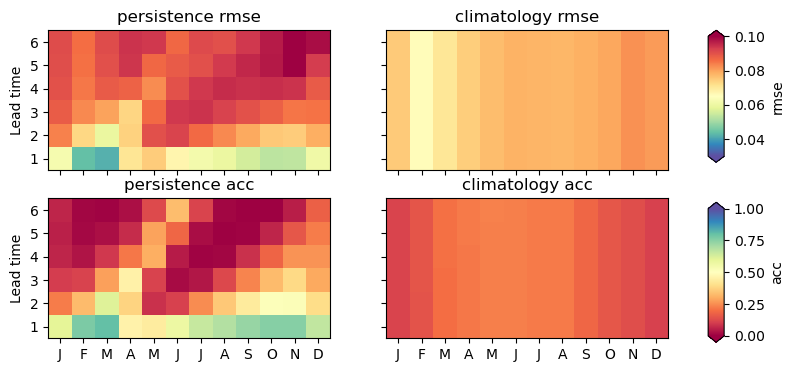

In [158]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,4), sharex=True, sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0,0].pcolormesh(x, y, persistence_rmse, cmap='Spectral_r', shading='flat', vmin=0.03, vmax=0.1)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"persistence rmse")

axs[0,1].pcolormesh(x, y, climatology_rmse, cmap='Spectral_r', shading='flat',  vmin=0.03, vmax=0.1)
axs[0,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,1].set_title(f"climatology rmse")

cax2 = axs[1,0].pcolormesh(x, y, persistence_acc, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"persistence acc")
axs[1,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])


axs[1,1].pcolormesh(x, y, climatology_acc, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[1,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,1].set_title(f"climatology acc")
axs[1,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.95, 0.55, 0.02, 0.33])
cbar_ax2 = fig.add_axes([0.95, 0.1, 0.02, 0.35])

plt.colorbar(cax, cax=cbar_ax, label=r'rmse', orientation='vertical', extend='both')
plt.colorbar(cax2, cax=cbar_ax2, label=r'acc', orientation='vertical', extend='both')

plt.savefig("figures/cesm/baselines_rmse_acc.jpg", dpi=300, bbox_inches='tight')

## In what seasons do the models perform the best over anomaly persistence?

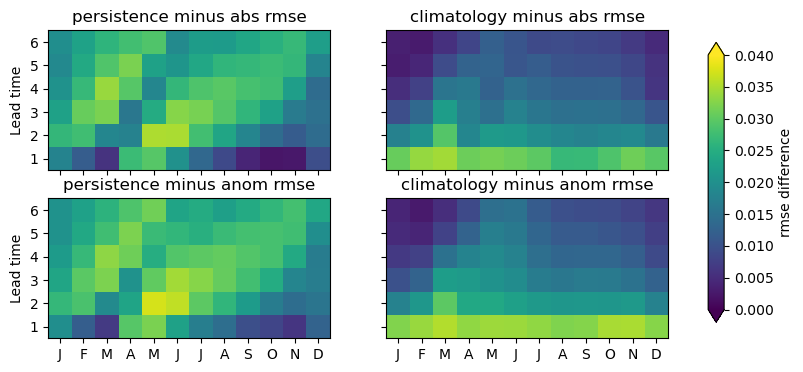

In [103]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,4), sharex=True, sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0,0].pcolormesh(x, y, persistence_rmse - abs_rmse, cmap='viridis', shading='flat', vmin=-0, vmax=0.04)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"persistence minus abs rmse")

axs[0,1].pcolormesh(x, y, climatology_rmse - abs_rmse, cmap='viridis', shading='flat', vmin=-0, vmax=0.04)
axs[0,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,1].set_title(f"climatology minus abs rmse")

axs[1,0].pcolormesh(x, y, persistence_rmse - anom_rmse, cmap='viridis', shading='flat', vmin=0, vmax=0.04)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"persistence minus anom rmse")
axs[1,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])


axs[1,1].pcolormesh(x, y, climatology_rmse - anom_rmse, cmap='viridis', shading='flat', vmin=0, vmax=0.04)
axs[1,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,1].set_title(f"climatology minus anom rmse")
axs[1,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
plt.colorbar(cax, cax=cbar_ax, label=r'rmse difference', orientation='vertical', extend='both')
plt.savefig("figures/cesm/baselines_rmse_diff_anom_vs_abs.jpg", dpi=300, bbox_inches='tight')

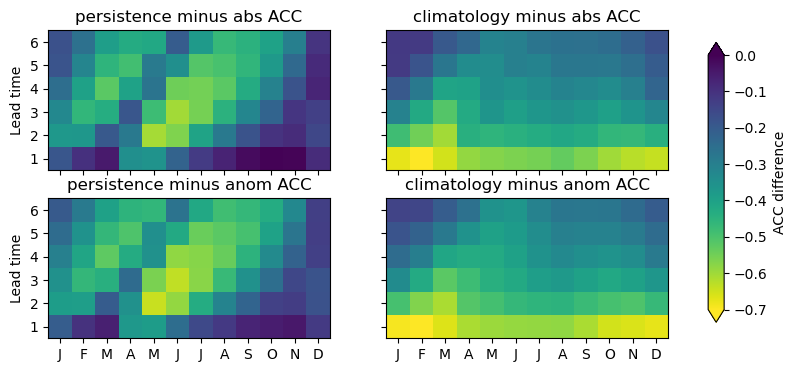

In [138]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,4), sharex=True, sharey=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0,0].pcolormesh(x, y, persistence_acc - abs_acc, cmap='viridis_r', shading='flat', vmin=-0.7, vmax=0)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"persistence minus abs ACC")

axs[0,1].pcolormesh(x, y, climatology_acc - abs_acc, cmap='viridis_r', shading='flat', vmin=-0.7, vmax=0)
axs[0,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,1].set_title(f"climatology minus abs ACC")

axs[1,0].pcolormesh(x, y, persistence_acc - anom_acc, cmap='viridis_r', shading='flat', vmin=-0.7, vmax=0)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"persistence minus anom ACC")
axs[1,0].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])


axs[1,1].pcolormesh(x, y, climatology_acc - anom_acc, cmap='viridis_r', shading='flat', vmin=-0.7, vmax=0)
axs[1,1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,1].set_title(f"climatology minus anom ACC")
axs[1,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC difference', orientation='vertical', extend='both')
plt.savefig("figures/cesm/baselines_acc_diff_anom_vs_abs.jpg", dpi=300, bbox_inches='tight')

## Look at extremes in the target dataset

In [9]:
sia_anom = (abs_prediction_diagnostics.targets_anomaly.isel(lead_time=0) * reference_grid.area).sum(("x","y")) / 1e12

sia_anom_smoothed = sia_anom.rolling(start_prediction_month=24, center=True).mean()


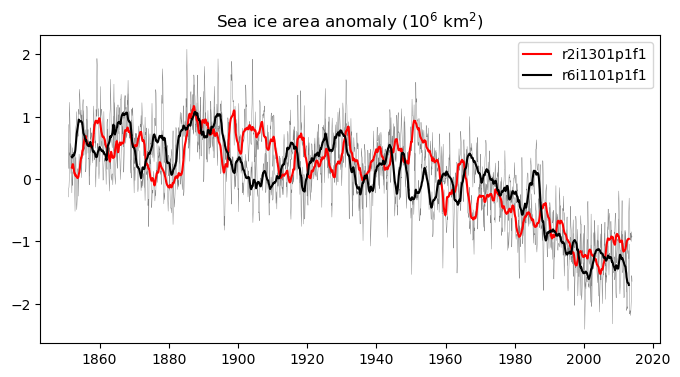

In [204]:
# let's plot the timeseries
plt.figure(figsize=(8,4)) 
sia_anom.isel(member_id=0).plot(color='gray', linewidth=0.3)
sia_anom.isel(member_id=1).plot(color='gray', linewidth=0.3)
sia_anom_smoothed.isel(member_id=0).plot(color='r', label=sia_anom.member_id.isel(member_id=0).values)
sia_anom_smoothed.isel(member_id=1).plot(color='k', label=sia_anom.member_id.isel(member_id=1).values)
plt.title(rf"Sea ice area anomaly (10$^6$ km$^2$)")
plt.legend()
plt.xlabel("")
plt.savefig("figures/cesm/initial_experiment/sia_anomaly_timeseries.jpg", dpi=300, bbox_inches="tight")

In [213]:
print(sia_anom.argmin(("member_id","start_prediction_month")), "\n")
print(sia_anom.argmax(("member_id","start_prediction_month")))

{'member_id': <xarray.DataArray ()> Size: 8B
array(0)
Coordinates:
    lead_time  int64 8B 1, 'start_prediction_month': <xarray.DataArray ()> Size: 8B
array(1791)
Coordinates:
    lead_time  int64 8B 1} 

{'member_id': <xarray.DataArray ()> Size: 8B
array(0)
Coordinates:
    lead_time  int64 8B 1, 'start_prediction_month': <xarray.DataArray ()> Size: 8B
array(411)
Coordinates:
    lead_time  int64 8B 1}


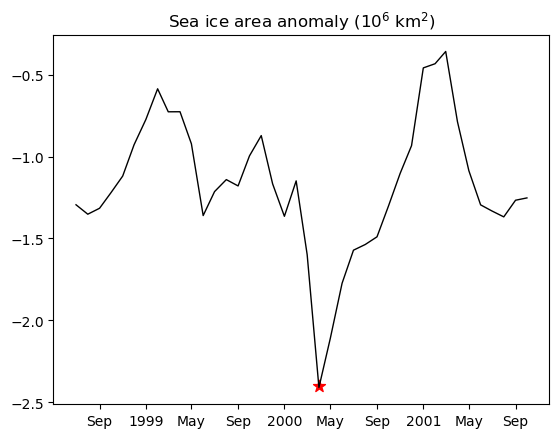

In [228]:
sia_anom.isel(member_id=0, start_prediction_month=slice(1770, 1810)).plot(color='k', linewidth=1)
plt.scatter(sia_anom.start_prediction_month.isel(start_prediction_month=1791), -2.4, color='r', marker='*', s=80)
plt.title(rf"Sea ice area anomaly (10$^6$ km$^2$)")
plt.xlabel("")
plt.savefig("figures/cesm/initial_experiment/sia_anomaly_minimum.jpg", dpi=300, bbox_inches="tight")

### what were the models doing for this huge extreme?

In [242]:
pred_sia_anom.isel(lead_time=5, start_prediction_month=slice(1770-5, 1810-5))


<xarray.DataArray (start_prediction_month: 0)> Size: 0B
array([], dtype=float64)
Coordinates:
  * start_prediction_month  (start_prediction_month) datetime64[ns] 0B 
    member_id               <U11 44B 'r2i1301p1f1'
    lead_time               int64 8B 6

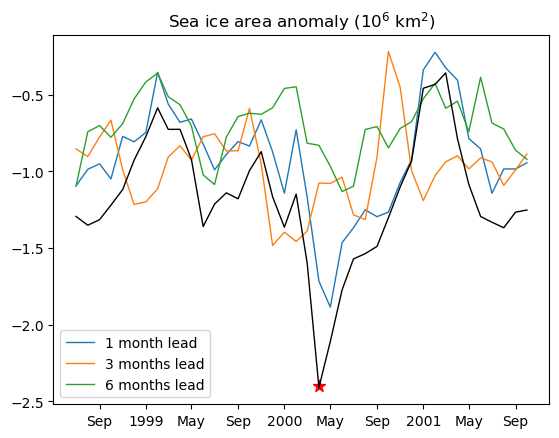

In [260]:
# let's get the predictions made by the model 
pred_anom = anom_prediction_diagnostics.predictions_anomaly.isel(member_id=0) / 1e12

pred_sia_anom = (pred_anom * reference_grid.area).sum(("x","y")).isel(start_prediction_month=slice(1770, 1810))

pred_sia_anom.isel(lead_time=0).plot(label="1 month lead", linewidth=1)
pred_sia_anom.isel(lead_time=2).roll(start_prediction_month=-2).plot(label="3 months lead", linewidth=1)
pred_sia_anom.isel(lead_time=5).roll(start_prediction_month=-5).plot(label="6 months lead",linewidth=1)

sia_anom.isel(member_id=0, start_prediction_month=slice(1770, 1810)).plot(color='k', linewidth=1)
plt.scatter(sia_anom.start_prediction_month.isel(start_prediction_month=1791), -2.4, color='r', marker='*', s=80)
plt.title(rf"Sea ice area anomaly (10$^6$ km$^2$)")
plt.xlabel("")
plt.legend()
#plt.savefig("figures/cesm/initial_experiment/sia_anomaly_minimum_withpred.jpg", dpi=300, bbox_inches="tight")

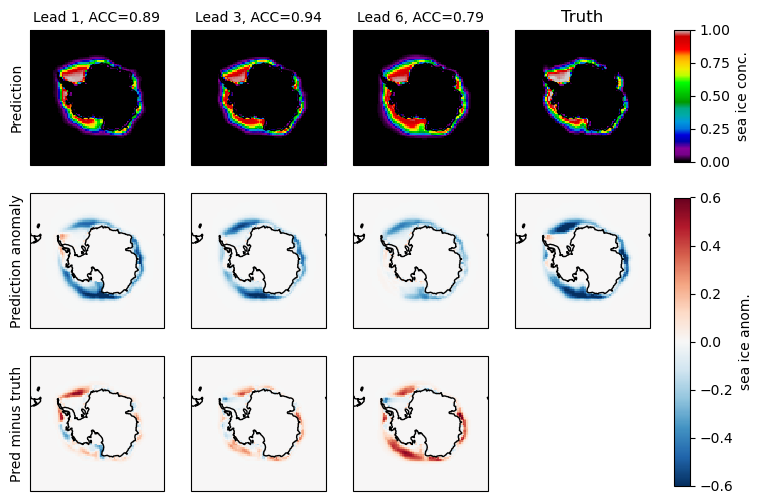

In [53]:
import cartopy.crs as ccrs

start_prediction_month = 1791
member_id = 0

lon = reference_grid.lon.data
lat = reference_grid.lat.data

fig, axs = plt.subplots(figsize=(8,6), nrows=3, ncols=4, 
                        sharex=True, sharey=True, 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})

contour_colors = np.arange(-0.4, 0.45, 0.05)

target_data_anom = anom_prediction_diagnostics.targets_anomaly.isel(start_prediction_month=1791,
        member_id=0, lead_time=0)
target_data = anom_prediction_diagnostics.targets.isel(start_prediction_month=1791,
        member_id=0, lead_time=0)

lead_times = [1, 3, 6]
for i in range(4):
    if i == 3:
        axs[0,i].pcolormesh(lon, lat, target_data, transform=ccrs.PlateCarree(),
                            vmin=0, vmax=1, cmap="nipy_spectral")
        axs[1,i].pcolormesh(lon, lat, target_data_anom, transform=ccrs.PlateCarree(),
                            vmin=-0.6, vmax=0.6, cmap='RdBu_r')
        axs[2,i].pcolormesh(lon, lat, target_data_anom, transform=ccrs.PlateCarree(),
                            vmin=-0.6, vmax=0.6, cmap='RdBu_r')
        axs[0,i].set_title("Truth")
    else:
        lead = (lead_times[i] - 1)
        pred_data = abs_prediction_diagnostics.predictions.isel(start_prediction_month=start_prediction_month-lead, 
            member_id=member_id, lead_time=lead)
        pred_data_anom = abs_prediction_diagnostics.predictions_anomaly.isel(start_prediction_month=start_prediction_month-lead, 
            member_id=member_id, lead_time=lead)

        cax = axs[0,i].pcolormesh(lon, lat, 
                        pred_data, 
                        transform=ccrs.PlateCarree(), 
                        cmap='nipy_spectral', vmin=0, vmax=1)
        
        cax2 = axs[1,i].pcolormesh(lon, lat, 
                    pred_data_anom, 
                    transform=ccrs.PlateCarree(), 
                    cmap='RdBu_r', vmin=-0.6, vmax=0.6)

        axs[2,i].pcolormesh(lon, lat, 
                        pred_data_anom - target_data_anom, 
                        transform=ccrs.PlateCarree(), 
                        cmap='RdBu_r', vmin=-0.6, vmax=0.6)

        corr = np.corrcoef(pred_data_anom.values.flatten(), target_data_anom.values.flatten())[0,1]
        axs[1,i].set_xticks([])
        axs[0,i].set_yticks([])
        axs[1,i].set_yticks([])
        axs[0,i].set_title(f"Lead {lead+1}, ACC={np.round(corr,2)}", fontsize=10)

    for j in range(3):
        axs[j,i].coastlines()
        axs[j,i].set_yticks([])

axs[0,0].set_ylabel("Prediction")
axs[1,0].set_ylabel("Prediction anomaly")
axs[2,0].set_ylabel("Pred minus truth")

fig.delaxes(axs[2,3])

cbar_ax = fig.add_axes([0.93, 0.66, 0.02, 0.22])
cbar_ax2 = fig.add_axes([0.93, 0.12, 0.02, 0.48])

plt.colorbar(cax, cax=cbar_ax, label=r'sea ice conc.', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'sea ice anom.', orientation='vertical')


# init_month = pd.Timestamp(predictions2_anom.start_prediction_month[start_prediction_month - 1].values)
# actual_member_id = predictions2_anom.member_id[member_id].values
# plt.suptitle(f"init_month = {init_month.year}-{init_month.month}, member_id = {actual_member_id}, model_config=simple_inputs")
#plt.savefig("figures/cesm/initial_experiment/extremes/abs_spatial_maps_leadtime.jpg", dpi=300, bbox_inches='tight')

In [92]:
pred_sia_anom = (anom_prediction_diagnostics.predictions_anomaly * reference_grid.area).sum(("x","y")) / 1e12
pred_sia_abs = (abs_prediction_diagnostics.predictions_anomaly * reference_grid.area).sum(("x","y")) / 1e12
persistence_sia = (persistence_anom * reference_grid.area).sum(("x","y")) / 1e12

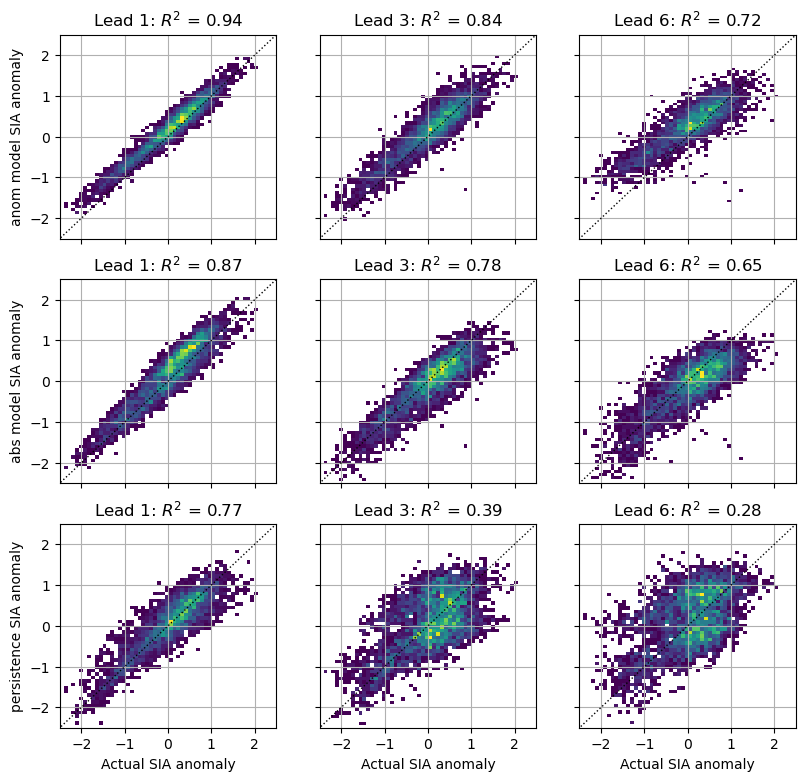

In [100]:

fix, axs = plt.subplots(figsize=(9.5,9), nrows=3, ncols=3, sharex=True, sharey=True)

lead_times = [1, 3, 6]
for i in range(3):
    for j in range(3):
        lead = lead_times[j] - 1
        if i == 0:
            pred_to_plot = pred_sia_anom.isel(lead_time=lead).roll(start_prediction_month=lead)
            pred_label = "anom model"
        elif i == 1:
            pred_to_plot = pred_sia_abs.isel(lead_time=lead).roll(start_prediction_month=lead)
            pred_label = "abs model"
        else:
            pred_to_plot = persistence_sia.isel(lead_time=lead).roll(start_prediction_month=lead)
            pred_label="persistence"
        
        axs[i,j].hist2d(sia_anom.to_numpy().flatten(), pred_to_plot.to_numpy().flatten(), bins=50, cmin=1)

        # plot 1 to 1 line
        axs[i,j].plot([-4,4], [-4,4], color='k', linewidth=1, linestyle='dotted')
        
        # format
        axs[i,j].grid(True)
        axs[i,j].set_ylim(-2.5, 2.5)
        axs[i,j].set_xlim(-2.5, 2.5)
        axs[i,0].set_ylabel(f"{pred_label} SIA anomaly")
        axs[2,j].set_xlabel("Actual SIA anomaly")

        # compute R^2 
        r = np.corrcoef(sia_anom.to_numpy().flatten(), pred_to_plot.to_numpy().flatten())
        axs[i,j].set_title(rf"Lead {lead+1}: $R^2$ = {np.round(r[0,1] ** 2,2)}")

plt.savefig("figures/cesm/initial_experiment/sia_prediction_distribution.jpg", dpi=300, bbox_inches='tight')

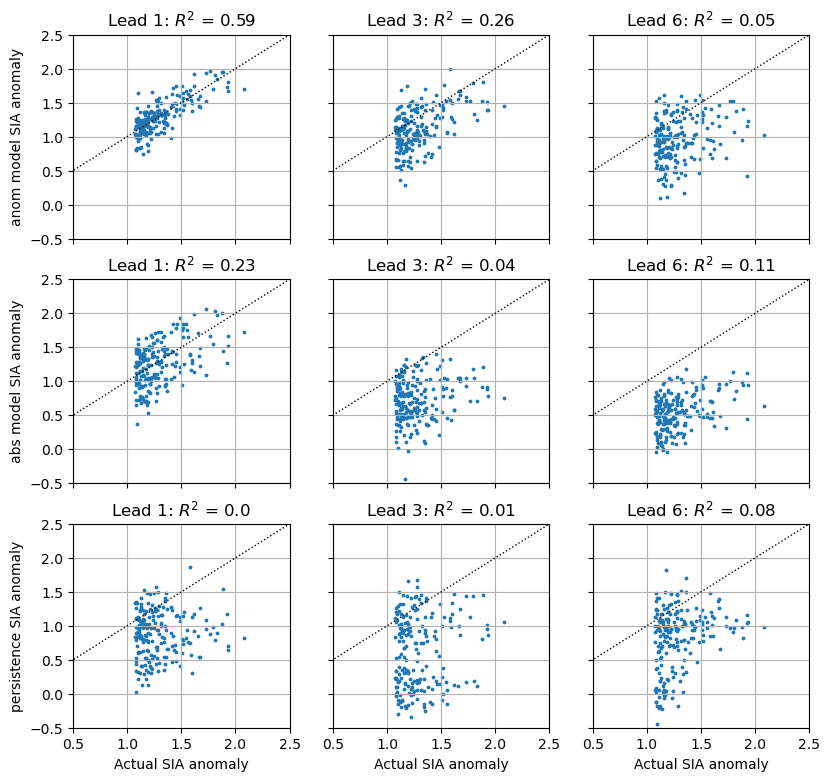

In [126]:
# select the 5% tails 
sorted_idx = np.argsort(sia_anom.to_numpy().flatten())

sia_anom_sorted = sia_anom.to_numpy().flatten()[sorted_idx]

n_samples = round(len(sia_anom_sorted) / 20)

fix, axs = plt.subplots(figsize=(9.5,9), nrows=3, ncols=3, sharex=True, sharey=True)

lead_times = [1, 3, 6]
for i in range(3):
    for j in range(3):
        lead = lead_times[j] - 1
        if i == 0:
            pred_to_plot = pred_sia_anom.isel(lead_time=lead).roll(start_prediction_month=lead)
            pred_label = "anom model"
        elif i == 1:
            pred_to_plot = pred_sia_abs.isel(lead_time=lead).roll(start_prediction_month=lead)
            pred_label = "abs model"
        else:
            pred_to_plot = persistence_sia.isel(lead_time=lead).roll(start_prediction_month=lead)
            pred_label="persistence"
        
        x = sia_anom_sorted[-n_samples:]
        y = pred_to_plot.to_numpy().flatten()[sorted_idx][-n_samples:]
        axs[i,j].scatter(x, y, s=3)

        # plot 1 to 1 line
        axs[i,j].plot([-4,4], [-4,4], color='k', linewidth=1, linestyle='dotted')
        
        # format
        axs[i,j].grid(True)
        axs[i,j].set_ylim(-0.5, 2.5)
        axs[i,j].set_xlim(0.5, 2.5)
        axs[i,0].set_ylabel(f"{pred_label} SIA anomaly")
        axs[2,j].set_xlabel("Actual SIA anomaly")

        # compute R^2 
        r = np.corrcoef(x,y)
        axs[i,j].set_title(rf"Lead {lead+1}: $R^2$ = {np.round(r[0,1] ** 2,2)}")

plt.savefig("figures/cesm/initial_experiment/extremes/sia_prediction_distribution_max_extremes.jpg", dpi=300, bbox_inches='tight')

In [ ]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,5), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, 100 * persistence_error, cmap='Spectral_r', shading='flat', vmin=0, vmax=60)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"anomaly persistence")

axs[1].pcolormesh(x, y, 100 * climatology_error, cmap='Spectral_r', shading='flat', vmin=0, vmax=60)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("climatology")

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
plt.colorbar(cax, cax=cbar_ax, label=r'mean percent error (%)', orientation='vertical', extend='max')
plt.savefig("figures/cesm/initial_experiment/baseline_models_MPE.jpg", dpi=300, bbox_inches='tight')

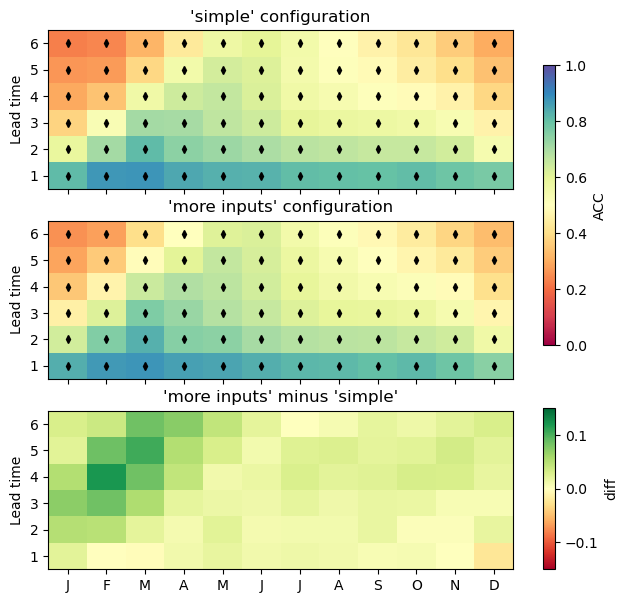

In [81]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

exceeds_persistence = model1_acc_spatial > persistence_acc_spatial
exceeds_climatology = model1_acc_spatial > climatology_acc_spatial
cax = axs[0].pcolormesh(x, y, model1_acc_spatial, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"'simple' configuration")
plot_markers(axs[0], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

exceeds_persistence = model2_acc_spatial > persistence_acc_spatial
exceeds_climatology = model2_acc_spatial > climatology_acc_spatial
axs[1].pcolormesh(x, y, model2_acc_spatial, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("'more inputs' configuration")
plot_markers(axs[1], exceeds_persistence, exceeds_climatology, x_centers, y_centers)

cax2 = axs[2].pcolormesh(x, y, (model2_acc_spatial - model1_acc_spatial), cmap='RdYlGn', shading='flat', vmin=-0.15, vmax=0.15)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("'more inputs' minus 'simple'")


cbar_ax = fig.add_axes([0.95, 0.43, 0.02, 0.4])
cbar_ax2 = fig.add_axes([0.95, 0.11, 0.02, 0.23])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'diff', orientation='vertical')
plt.savefig("figures/cesm/simple_vs_more-inputs_ACC.jpg", dpi=300, bbox_inches='tight')

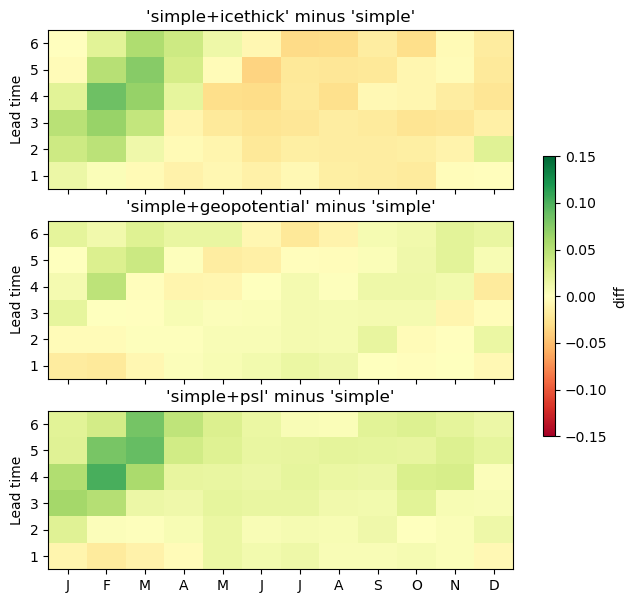

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,7), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

cax = axs[0].pcolormesh(x, y, (icethick_acc_spatial - model1_acc_spatial), cmap='RdYlGn', shading='flat', vmin=-0.15, vmax=0.15)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title("'simple+icethick' minus 'simple'")

axs[1].pcolormesh(x, y, (geopotential_acc_spatial - model1_acc_spatial), cmap='RdYlGn', shading='flat', vmin=-0.15, vmax=0.15)
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("'simple+geopotential' minus 'simple'")

cax2 = axs[2].pcolormesh(x, y, (psl_acc_spatial - model1_acc_spatial), cmap='RdYlGn', shading='flat', vmin=-0.15, vmax=0.15)
axs[2].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[2].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[2].set_ylabel("Lead time")
axs[2].set_title("'simple+psl' minus 'simple'")


cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
plt.colorbar(cax, cax=cbar_ax, label=r'diff', orientation='vertical')
plt.savefig("figures/cesm/ACC_change_add_inputs_separately.jpg", dpi=300, bbox_inches='tight')

In [97]:
model1_acc_spatial_full.argmin(("start_prediction_month", "member_id"))

{'start_prediction_month': <xarray.DataArray (lead_time: 6)> Size: 48B
 array([ 345, 1614,  844,  270, 1436,  682])
 Coordinates:
   * lead_time  (lead_time) int64 48B 1 2 3 4 5 6,
 'member_id': <xarray.DataArray (lead_time: 6)> Size: 48B
 array([1, 1, 1, 1, 0, 1])
 Coordinates:
   * lead_time  (lead_time) int64 48B 1 2 3 4 5 6}

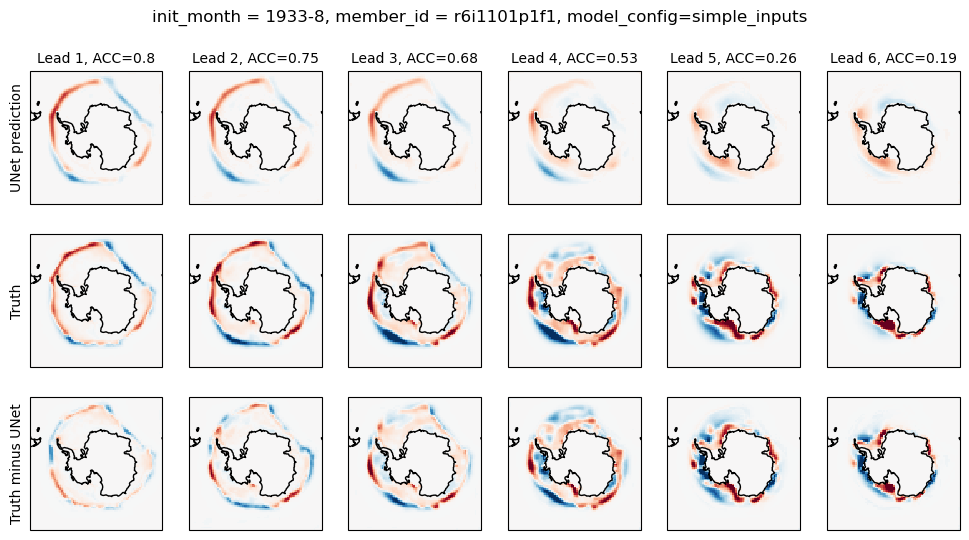

In [152]:
import cartopy.crs as ccrs

start_prediction_month = 998-6
member_id = 1

lon = reference_grid.lon.data
lat = reference_grid.lat.data

fig, axs = plt.subplots(figsize=(12,6), nrows=3, ncols=6, 
                        sharex=True, sharey=True, 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
contour_colors = np.arange(-0.4, 0.45, 0.05)

for i in range(6):
    pred_data = predictions1_anom.isel(start_prediction_month=start_prediction_month, member_id=member_id, lead_time=i)
    target_data = targets.isel(start_prediction_month=start_prediction_month, member_id=member_id, lead_time=i)

    axs[0,i].pcolormesh(lon, lat, 
                    pred_data, 
                    transform=ccrs.PlateCarree(), 
                    cmap='RdBu_r', vmin=-0.4, vmax=0.4)

    axs[1,i].pcolormesh(lon, lat, 
                    target_data, 
                    transform=ccrs.PlateCarree(), 
                    cmap='RdBu_r', vmin=-0.4, vmax=0.4)

    axs[2,i].pcolormesh(lon, lat, 
                    target_data - pred_data, 
                    transform=ccrs.PlateCarree(), 
                    cmap='RdBu_r', vmin=-0.4, vmax=0.4)

    for j in range(3):
        axs[j,i].coastlines()
        axs[j,i].set_yticks([])

    corr = np.corrcoef(pred_data.values.flatten(), target_data.values.flatten())[0,1]
    axs[1,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_yticks([])
    axs[0,i].set_title(f"Lead {i+1}, ACC={np.round(corr,2)}", fontsize=10)

axs[0,0].set_ylabel("UNet prediction")
axs[1,0].set_ylabel("Truth")
axs[2,0].set_ylabel("Truth minus UNet")

init_month = pd.Timestamp(predictions2_anom.start_prediction_month[start_prediction_month - 1].values)
actual_member_id = predictions2_anom.member_id[member_id].values
plt.suptitle(f"init_month = {init_month.year}-{init_month.month}, member_id = {actual_member_id}, model_config=simple_inputs")

#plt.savefig("figures/cesm/initial_experiment/simple_inputs_example2.jpg", dpi=300, bbox_inches='tight')